In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import classifiers
from datetime import datetime, timezone
import plotly.graph_objects as go
import itertools
from autocorrect import Speller
import re, string, timeit
import folium
from wordcloud import WordCloud
import scipy
import pyreadstat
%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/daisy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
sightings = pd.read_pickle('sightings_add_UTC')
sightings.head(8)

,Date_Time,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary,Detail_Summary_nltk,Notes,Country,City,State,Location,Lat,Lon,timezone_str,Time_UTC
0,2021-04-23 06:30:00,Circle,9 minutes,Very strange ((NUFORC Note: Rocket launch f...,4/23/21,http://www.nuforc.org/webreports/162/S162815.html,\nVery strangeI have recorded a video of this ...,strange recorded video fighting,NaN,United States,Blackshear,GA,"Blackshear, GA United States",31.304430,-82.240580,America/New_York,2021-04-23 10:30:00+00:00
1,2021-04-23 06:00:00,Circle,Seconds,Ball in the sky ((NUFORC Note: Rocket launc...,4/23/21,http://www.nuforc.org/webreports/162/S162814.html,\nBall in the skyObject appears as a white bal...,ball skyobject appears white ball vapor screwi...,NaN,United States,Thompson,VA,"Thompson, VA United States",37.781980,-79.974385,America/New_York,2021-04-23 10:00:00+00:00
2,2021-04-23 06:00:00,Light,5 minutes,I was driving and saw something strange in the...,4/23/21,http://www.nuforc.org/webreports/162/S162822.html,\nI was driving and saw something strange in t...,driving saw something strange sky pulled car i...,NaN,United States,Vero Beach,FL,"Vero Beach, FL United States",27.638850,-80.393960,America/New_York,2021-04-23 10:00:00+00:00
3,2021-04-23 05:59:00,Light,3 minutes,2 extremely bright lights appeared over east c...,4/23/21,http://www.nuforc.org/webreports/162/S162824.html,\n2 extremely bright lights appeared over east...,2 extremely bright light appeared east coast n...,NaN,United States,Saint Augustine,FL,"Saint Augustine, FL United States",29.894690,-81.314520,America/New_York,2021-04-23 09:59:00+00:00
4,2021-04-23 05:58:00,Cone,>5 minutes,A cone of light coming from the sky unlike any...,4/23/21,http://www.nuforc.org/webreports/162/S162819.html,\nA cone of light coming from the sky unlike a...,cone light coming sky unlike anything ever see...,NaN,United States,Durham,NC,"Durham, NC United States",35.995420,-78.896440,America/New_York,2021-04-23 09:58:00+00:00
5,2021-04-23 05:55:00,Sphere,10 minutes,Noticed a intense light that was covering a la...,4/23/21,http://www.nuforc.org/webreports/162/S162823.html,\nDriving on I-16 south and noticed a intense ...,driving 16 south noticed intense light coverin...,NaN,United States,I-16 south,GA,"I-16 south, GA United States",32.071949,-81.223154,America/New_York,2021-04-23 09:55:00+00:00
6,2021-04-23 05:54:00,Light,5 minutes,Two bright lights one flashing with a descendi...,4/23/21,http://www.nuforc.org/webreports/162/S162820.html,\nTwo bright lights one flashing with a descen...,two bright light one flashing descending expan...,NaN,United States,Parrish,FL,"Parrish, FL United States",27.577620,-82.425460,America/New_York,2021-04-23 09:54:00+00:00
7,2021-04-23 05:45:00,Light,~10-15 minutes,Im former military and have never seen aircraf...,4/23/21,http://www.nuforc.org/webreports/162/S162826.html,\nIm former military and have never seen aircr...,former military never seen aircraft thatincide...,NaN,United States,Davenport,FL,"Davenport, FL United States",28.157990,-81.603400,America/New_York,2021-04-23 09:45:00+00:00


In [3]:
sightings.dtypes

Date_Time                   datetime64[ns]
Shape                               object
Duration                            object
Summary                             object
Posted                              object
Detail_Link                         object
Detail_Summary                      object
Detail_Summary_nltk                 object
Notes                               object
Country                             object
City                                object
State                               object
Location                            object
Lat                                float64
Lon                                float64
timezone_str                        object
Time_UTC               datetime64[ns, UTC]
dtype: object

In [4]:
#correcting 1900s to 2000s issue with date column
def fix_date(x):
    if x.year > 2021:
        return datetime(x.year - 100, x.month, x.day, x.hour, x.minute, x.second, x.microsecond, tzinfo=timezone.utc)
    else:
        return x
    

In [5]:
sightings['Time_UTC']=sightings['Time_UTC'].apply(fix_date)
sightings['Time_UTC']=pd.to_datetime(sightings['Time_UTC'], utc=True)
sightings.dtypes

Date_Time                   datetime64[ns]
Shape                               object
Duration                            object
Summary                             object
Posted                              object
Detail_Link                         object
Detail_Summary                      object
Detail_Summary_nltk                 object
Notes                               object
Country                             object
City                                object
State                               object
Location                            object
Lat                                float64
Lon                                float64
timezone_str                        object
Time_UTC               datetime64[ns, UTC]
dtype: object

In [6]:
sightings['Time_UTC']

0       2021-04-23 10:30:00+00:00
1       2021-04-23 10:00:00+00:00
2       2021-04-23 10:00:00+00:00
3       2021-04-23 09:59:00+00:00
4       2021-04-23 09:58:00+00:00
                   ...           
97243                         NaT
97244                         NaT
97247                         NaT
97248                         NaT
97249                         NaT
Name: Time_UTC, Length: 61647, dtype: datetime64[ns, UTC]

In [7]:
sightings.head()

,Date_Time,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary,Detail_Summary_nltk,Notes,Country,City,State,Location,Lat,Lon,timezone_str,Time_UTC
0,2021-04-23 06:30:00,Circle,9 minutes,Very strange ((NUFORC Note: Rocket launch f...,4/23/21,http://www.nuforc.org/webreports/162/S162815.html,\nVery strangeI have recorded a video of this ...,strange recorded video fighting,NaN,United States,Blackshear,GA,"Blackshear, GA United States",31.30443,-82.240580,America/New_York,2021-04-23 10:30:00+00:00
1,2021-04-23 06:00:00,Circle,Seconds,Ball in the sky ((NUFORC Note: Rocket launc...,4/23/21,http://www.nuforc.org/webreports/162/S162814.html,\nBall in the skyObject appears as a white bal...,ball skyobject appears white ball vapor screwi...,NaN,United States,Thompson,VA,"Thompson, VA United States",37.78198,-79.974385,America/New_York,2021-04-23 10:00:00+00:00
2,2021-04-23 06:00:00,Light,5 minutes,I was driving and saw something strange in the...,4/23/21,http://www.nuforc.org/webreports/162/S162822.html,\nI was driving and saw something strange in t...,driving saw something strange sky pulled car i...,NaN,United States,Vero Beach,FL,"Vero Beach, FL United States",27.63885,-80.393960,America/New_York,2021-04-23 10:00:00+00:00
3,2021-04-23 05:59:00,Light,3 minutes,2 extremely bright lights appeared over east c...,4/23/21,http://www.nuforc.org/webreports/162/S162824.html,\n2 extremely bright lights appeared over east...,2 extremely bright light appeared east coast n...,NaN,United States,Saint Augustine,FL,"Saint Augustine, FL United States",29.89469,-81.314520,America/New_York,2021-04-23 09:59:00+00:00
4,2021-04-23 05:58:00,Cone,>5 minutes,A cone of light coming from the sky unlike any...,4/23/21,http://www.nuforc.org/webreports/162/S162819.html,\nA cone of light coming from the sky unlike a...,cone light coming sky unlike anything ever see...,NaN,United States,Durham,NC,"Durham, NC United States",35.99542,-78.896440,America/New_York,2021-04-23 09:58:00+00:00


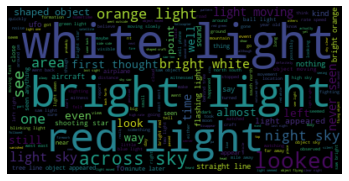

In [8]:
text = " ".join(t for t in sightings.Detail_Summary_nltk.astype(str))
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

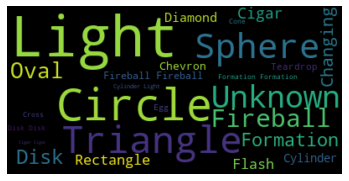

In [9]:
text = " ".join(t for t in sightings.Shape.astype(str))
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

In [10]:
# creating the Bag of words Model
BagOfWords = []
for s in sightings['Detail_Summary_nltk']:
    s = re.sub(r' . ', " ", s)
    s = re.sub(r'[\(\)\[\]\^\$\+\*\.\?\/!@#%&{}\'\",;:]', "", s)
    words = nltk.word_tokenize(s)
    BagOfWords.append(words)

In [11]:
BagOfWords_series = pd.Series(BagOfWords) 

In [12]:
BagOfWords_list = ''.join(BagOfWords_series.str.join(',').tolist()).split(',')

In [13]:
#spell = Speller(lang='en')
#for word in BagOfWords_list:
#    spell(word)

In [14]:
ngram_counts = Counter(ngrams(BagOfWords_list, 3))
ngram_counts.most_common(10)

[(('bright', 'white', 'light'), 2450),
 (('never', 'seen', 'anything'), 2253),
 (('seen', 'anything', 'like'), 1772),
 (('high', 'rate', 'speed'), 1322),
 (('bright', 'orange', 'light'), 989),
 (('moving', 'across', 'sky'), 972),
 (('saw', 'bright', 'light'), 718),
 (('light', 'looked', 'like'), 708),
 (('looked', 'like', 'star'), 691),
 (('get', 'better', 'look'), 667)]

In [15]:
#Sentiment Analyzer
sia = SentimentIntensityAnalyzer()
out = sia.polarity_scores(sightings.Detail_Summary_nltk[2])
out

{'neg': 0.058, 'neu': 0.733, 'pos': 0.209, 'compound': 0.9402}

In [16]:
TextBlob(sightings.Detail_Summary_nltk[2]).sentiment

Sentiment(polarity=0.21813725490196076, subjectivity=0.5176470588235293)

In [17]:
def sentiment(summary) -> float:
    """Compound has a range of -1 (negative) to +1 (positive), if 0 then neutral"""
    scores = [sia.polarity_scores(sentence)["compound"] for sentence in nltk.sent_tokenize(summary)]
    try:
        return np.mean(scores)
    except:
        return 0

In [18]:
sightings['sentiment'] = sightings['Detail_Summary_nltk'].apply(sentiment)

/Users/daisy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [19]:
sightings['sentiment']

0       -0.5106
1        0.3818
2        0.9402
3        0.4742
4       -0.2523
          ...  
97243   -0.7845
97244    0.2960
97247   -0.8176
97248    0.7003
97249    0.7506
Name: sentiment, Length: 61647, dtype: float64

In [20]:
#build a model
#training = [('so beautiful','pos'), 
#            ('They wanted to be friends','pos'),
#            ('never again', 'neg'),
#            ('The experience ruined my life','neg'),
#            ('the best thing I have even seen','pos'),
#            ('amazing','pos'),
#            ('I was scared and full of fear','neg'),
#            ('They were agressive and demanding','neg'),
#            ('I was abducted','neg')]
#testing = [('The colors were amazing','pos'), 
#           ('would never go there again','neg'),
#           ('life is so much better now','pos')]

In [21]:
#classifier = classifiers.NaiveBayesClassifier(training)

In [22]:
## decision tree classifier
#dt_classifier = classifiers.DecisionTreeClassifier(training)

In [23]:
#print (classifier.accuracy(testing))
#classifier.show_informative_features(3)

In [24]:
def TB_pos_neg(summary):
    scores = [TextBlob(sentence).sentiment[0] for sentence in nltk.sent_tokenize(summary)]
    try:
        return np.mean(scores)
    except:
        return 0

In [25]:
sightings['pos_neg'] = sightings['Detail_Summary_nltk'].apply(TB_pos_neg)

In [26]:
sightings.sample(8)

,Date_Time,Shape,Duration,Summary,Posted,Detail_Link,Detail_Summary,Detail_Summary_nltk,Notes,Country,City,State,Location,Lat,Lon,timezone_str,Time_UTC,sentiment,pos_neg
70822,2010-01-07 00:00:00,Fireball,3-4 secs,bright green comet or unidentified object that...,2/14/10,http://www.nuforc.org/webreports/074/S74007.html,\nbright green comet or unidentified object th...,bright green comet unidentified object appeare...,West Haven (viewed from),United States,Fair Haven,CT,"Fair Haven, CT United States",41.31211,-72.89624,America/New_York,2010-01-07 05:00:00+00:00,0.6705,0.103333
47253,2013-09-17 16:45:00,Other,10 seconds,Metallic forest green with a dark circle aroun...,9/30/13,http://www.nuforc.org/webreports/102/S102489.html,\nI was driving down a busy side street. I saw...,driving busy side street saw appeared first ho...,NaN,United States,Memphis,TN,"Memphis, TN United States",35.14976,-90.04925,America/Chicago,2013-09-17 21:45:00+00:00,0.6597,0.107143
35099,2015-02-05 19:30:00,Light,5 minutes,Bright lights multiplying,2/12/15,http://www.nuforc.org/webreports/117/S117198.html,\nBright lights multiplyingThere were 3 bright...,bright light multiplyingthere 3 bright light m...,NaN,United States,Camp Dennison,CO,"Camp Dennison, CO United States",39.19575,-84.28868,America/New_York,2015-02-06 00:30:00+00:00,0.8020,0.384211
20627,2017-07-04 22:00:00,Sphere,10 minutes,"Six UFO's in one night, five on video!",7/7/17,http://www.nuforc.org/webreports/134/S134982.html,"\nSix UFO's in one night, five on video!On Jul...",six fo one night five video july 4tharound 10 ...,NaN,United States,Franklin Square,NY,"Franklin Square, NY United States",40.70797,-73.68062,America/New_York,2017-07-05 02:00:00+00:00,-0.2732,0.139502
43701,2014-02-01 22:50:00,Formation,10 minutes,I walked out into my yard downtown Charleston ...,2/7/14,http://www.nuforc.org/webreports/106/S106923.html,\nI walked out into my yard downtown Charlesto...,walked yard downtown charleston 1150 pm anothe...,NaN,United States,Charleston,SC,"Charleston, SC United States",32.78115,-79.93160,America/New_York,2014-02-02 03:50:00+00:00,-0.4059,0.146740
47786,2013-08-26 09:30:00,Other,2 minutes,On the morning of August 26th a dark mushroom ...,9/9/13,http://www.nuforc.org/webreports/101/S101695.html,\nOn the morning of August 26th a dark mushroo...,morning august dark mushroom shaped object see...,NaN,United States,Bear,DE,"Bear, DE United States",39.62742,-75.66090,America/New_York,2013-08-26 13:30:00+00:00,0.6908,0.030882
15767,2018-08-14 19:00:00,Disk,2 minutes,We witnessed a few fighter jets flying around ...,8/17/18,http://www.nuforc.org/webreports/142/S142761.html,\nWe witnessed a few fighter jets flying aroun...,witnessed fighter jet flying around erratic pa...,NaN,United States,Myrtle Beach,SC,"Myrtle Beach, SC United States",33.69373,-78.88232,America/New_York,2018-08-14 23:00:00+00:00,0.0516,0.006667
62003,2011-10-06 20:03:00,Sphere,a matter of seconds,"Chilling, giant, bright, green ball of fire be...",1/24/12,http://www.nuforc.org/webreports/086/S86735.html,"\nChilling, giant, bright, green ball of fire ...",chilling giant bright green ball fire lakewood...,NaN,United States,Tampa,FL,"Tampa, FL United States",27.94653,-82.45927,America/New_York,2011-10-07 00:03:00+00:00,0.5967,0.093576


In [27]:
state_abr = {"Hawaii":"HI", "Alaska":"AK", "Washington":"WA", "Oregon":"OR", "California":"CA",
                        "Arizona":"AZ", "Utah":"UT", "Idaho":"ID", "Montana":"MT", "Wyoming":"WY", "Colorado":"CO",
                        "New Mexico":"NM", "Texas":"TX", "Oklahoma":"OK", "Kansas":"KS", "Nebraska":"NE", 
                        "South Dakota":"SD", "North Dakota":"ND", "Minnesota":"MN", "Iowa":"IA", "Missouri":"MO",
                        "Arkansas":"AR", "Louisiana":"LA", "Wisconsin":"WI", "Illinois":"IL", "Mississippi":"MS",
                        "Alabama":"AL", "Georgia":"GA", "Florida":"FL", "Tennessee":"TN", "Kentucky":"KY", "Indiana":"IN",
                        "Michigan":"MI", "South Carolina":"SC", "North Carolina":"NC", "Virginia":"VA",
                        "West Virginia":"WV", "Ohio":"OH", "Pennsylvania":"PA", "Maryland":"MD", "Delaware":"DE",
                        "New Jersey":"NJ", "New York":"NY", "Connecticut":"CT", "Rhode Island":"RI", 
                        "Massachusetts":"MA", "Vermont":"VT", "New Hampshire":"NH", "Maine":"ME",
                        "District of Columbia":"DC", "Nevada":"NV", "Puerto Rico":"PR"}

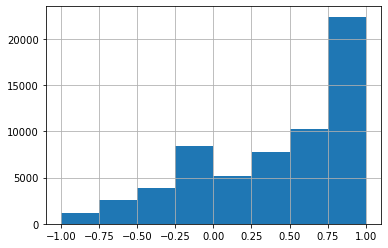

In [28]:
hist = sightings['sentiment'].hist(bins=8)

In [29]:
def objectivity(summary) -> float:
    """reports a float within the range [0.0, 1.0] where 0.0 is a very objective sentence and 1.0 is very subjective"""
    scores = [TextBlob(sentence).sentiment[1] for sentence in nltk.sent_tokenize(summary)]
    try:
        return np.mean(scores)
    except:
        return 0

In [30]:
sightings['objectivity'] = sightings['Detail_Summary_nltk'].apply(objectivity)

/Users/daisy/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [31]:
byStateSentObj = sightings[['State', 'sentiment', 'pos_neg', 'objectivity']].copy().replace(['', 'ON', 'BC'], None)
byStateSentObj.rename(columns = {'State':'state', 'sentiment': 'sentiment_nltk', 'pos_neg':'sentiment_textBlob'}, inplace = True)
byStateSentObj['state'] = byStateSentObj['state'].apply(lambda x: list(state_abr.keys())[list(state_abr.values()).index(x)])
byStateSentObj = byStateSentObj.groupby('state').agg({'sentiment_nltk': ['mean','median'], 'sentiment_textBlob': ['mean','median'], 'objectivity':['mean', 'median']}).reset_index()
byStateSentObj

state sentiment_nltk          sentiment_textBlob            \
                                   mean   median               mean    median   
0                Alabama       0.404351  0.58540           0.130834  0.125000   
1                 Alaska       0.407297  0.47670           0.141746  0.133491   
2                Arizona       0.395320  0.51060           0.137800  0.134178   
3               Arkansas       0.392786  0.51340           0.147803  0.142532   
4             California       0.453188  0.61240           0.134659  0.133226   
5               Colorado       0.422704  0.58590           0.140124  0.136429   
6            Connecticut       0.398429  0.54230           0.134894  0.132967   
7               Delaware       0.315494  0.42150           0.137809  0.130500   
8   District of Columbia       0.370191  0.39185           0.128490  0.115629   
9                Florida       0.386909  0.51060           0.130932  0.127207   
10               Georgia       0.413360  0.55740           0.134172  0.131120   
11                Hawaii       0.475718  0.61240           0.139117  0.139216   
12                 Idaho       0.416169  0.51060           0.142715  0.131941   
13              Illinois       0.425859  0.59940           0.134278  0.130000   
14               Indiana       0.382965  0.49390           0.138768  0.136199   
15                  Iowa       0.397461  0.54450           0.145230  0.141288   
16                Kansas       0.438454  0.59940           0.136712  0.138485   
17              Kentucky       0.370506  0.49390           0.134901  0.136310   
18             Louisiana       0.374539  0.47670           0.124888  0.120000   
19                 Maine       0.425755  0.59940           0.136237  0.133333   
20              Maryland       0.421678  0.57190           0.131226  0.128285   
21         Massachusetts       0.408707  0.54230           0.136599  0.127607   
22              Michigan       0.429033  0.58590           0.139946  0.138538   
23             Minnesota       0.415364  0.52670           0.145864  0.142000   
24           Mississippi       0.409668  0.55840           0.125576  0.126286   
25              Missouri       0.438528  0.58590           0.132882  0.131861   
26               Montana       0.426499  0.57190           0.145599  0.142857   
27              Nebraska       0.378097  0.52670           0.131714  0.129810   
28                Nevada       0.437826  0.58590           0.131697  0.133333   
29         New Hampshire       0.411620  0.57020           0.136148  0.135333   
30            New Jersey       0.397526  0.51060           0.132421  0.128061   
31            New Mexico       0.420909  0.58590           0.136670  0.133333   
32              New York       0.412930  0.52670           0.132776  0.130639   
33        North Carolina       0.397051  0.52670           0.137140  0.133333   
34          North Dakota       0.414051  0.59940           0.149122  0.139076   
35                  Ohio       0.386651  0.52670           0.139557  0.137457   
36              Oklahoma       0.426352  0.57190           0.144039  0.137637   
37                Oregon       0.469900  0.61240           0.137608  0.133333   
38          Pennsylvania       0.400704  0.52670           0.134197  0.131256   
39          Rhode Island       0.372416  0.49430           0.135882  0.133410   
40        South Carolina       0.367593  0.45880           0.146483  0.141971   
41          South Dakota       0.409767  0.51060           0.144487  0.146585   
42             Tennessee       0.413334  0.57190           0.134237  0.131757   
43                 Texas       0.451985  0.62490           0.133601  0.130632   
44                  Utah       0.435545  0.58590           0.132988  0.131081   
45               Vermont       0.428830  0.57890           0.153409  0.146111   
46              Virginia       0.392103  0.51060           0.128221  0.129048   
47            Washington       0.457882  0.62490  

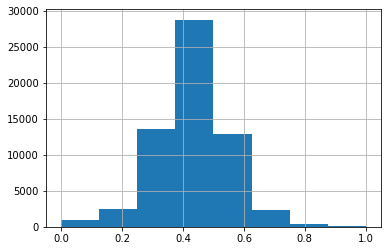

In [32]:
hist = sightings['objectivity'].hist(bins=8)

In [33]:
#save file
fileName = 'sightingsCapstone.pkl'
sightings.to_pickle(fileName)

<AxesSubplot:>

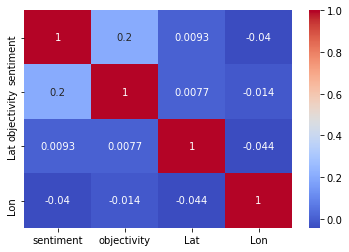

In [34]:
#load fresh file to work with
sightings_sentiment = pd.read_pickle(fileName)

sns.heatmap(sightings_sentiment[['sentiment', 'objectivity', 'Lat', 'Lon']].corr(), annot = True, fmt='.2g',cmap= 'coolwarm') 

In [35]:
#visualize data

ufo_df = sightings_sentiment[['sentiment', 'objectivity', 'Lat', 'Lon', 'Time_UTC', 'City', 'State', 'Country', 'Shape', 'pos_neg']].copy()
ufo_df = ufo_df[ufo_df['Country'] == 'United States']
ufo_df.dropna(how='any', inplace=True)

# Set x axis, group y axis
ufo_df['year'] = ufo_df['Time_UTC'].dt.year
ufo_df['day'] = ufo_df['Time_UTC'].dt.dayofyear
ufo_df['hour'] = ufo_df['Time_UTC'].dt.hour


In [36]:
ufo_df['sentiment_D'] = ufo_df['sentiment']>0
ufo_df['sentiment_D']= ufo_df['sentiment_D'].astype(int)

In [37]:
ufo_df['objectivity_D'] = ufo_df['objectivity']>0.5
ufo_df['objectivity_D']=ufo_df['objectivity_D'].astype(int)

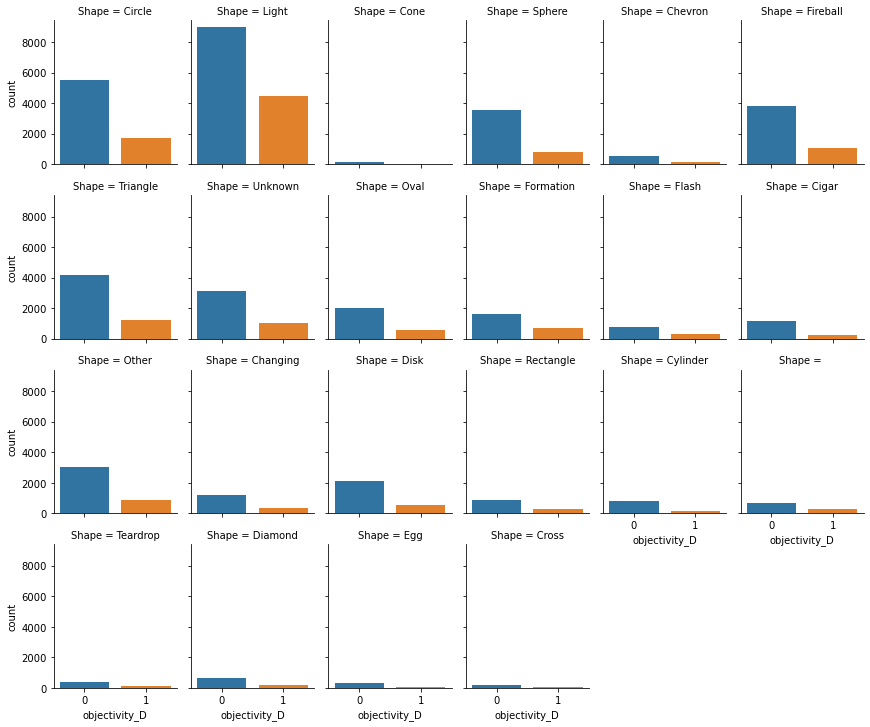

In [38]:
g = sns.catplot(x="objectivity_D", col="Shape", col_wrap=6,
                data=ufo_df,
                kind="count", height=2.5, aspect=.8)

In [39]:
ufo_df.iloc[[0]]

,sentiment,objectivity,Lat,Lon,Time_UTC,City,State,Country,Shape,pos_neg,year,day,hour,sentiment_D,objectivity_D
0,-0.5106,0.15,31.30443,-82.24058,2021-04-23 10:30:00+00:00,Blackshear,GA,United States,Circle,-0.05,2021,113,10,0,0


In [40]:
len(ufo_df[ufo_df.year>2021])

0

In [41]:
sightings.loc[96802]

Date_Time                                            2057-06-30 13:00:00
Shape                                                             Circle
Duration                                                      90 seconds
Summary                Slow travel when observed, followed by an abru...
Posted                                                            6/2/13
Detail_Link             http://www.nuforc.org/webreports/098/S98115.html
Detail_Summary         \nSlow travel when observed, followed by an ab...
Detail_Summary_nltk    slow travel observed followed abrupt direction...
Notes                                                                NaN
Country                                                    United States
City                                                          Burlington
State                                                                 IA
Location                                    Burlington, IA United States
Lat                                                

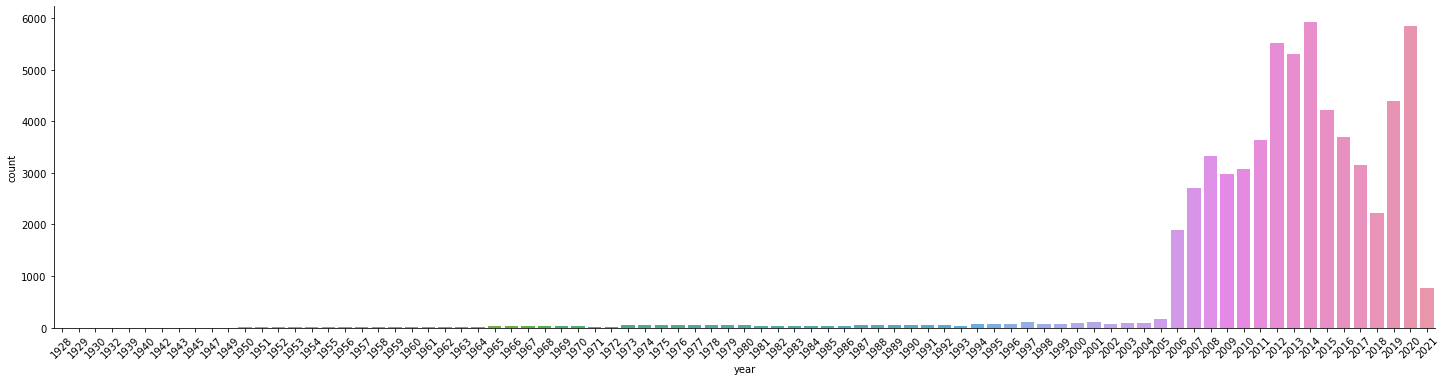

In [42]:
g = sns.catplot(x="year", kind = 'count', data = ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

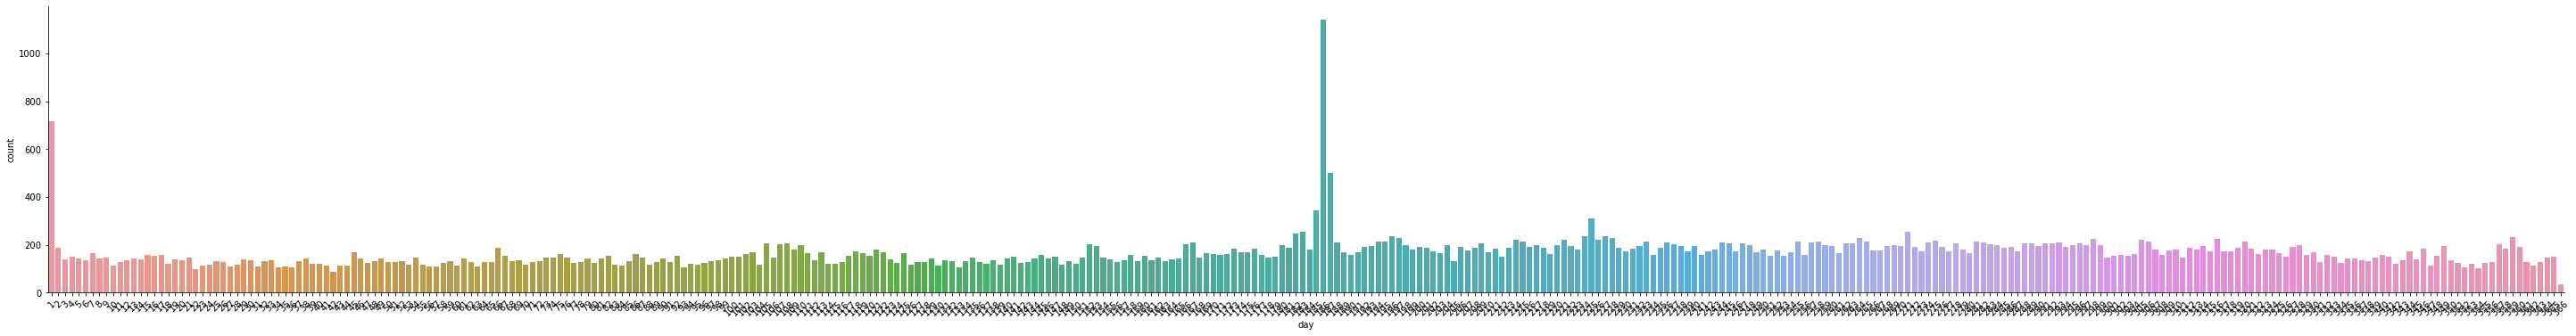

In [43]:
g = sns.catplot(x="day", kind = 'count', data = ufo_df, height=5, aspect=8)
g.set_xticklabels(rotation=45)

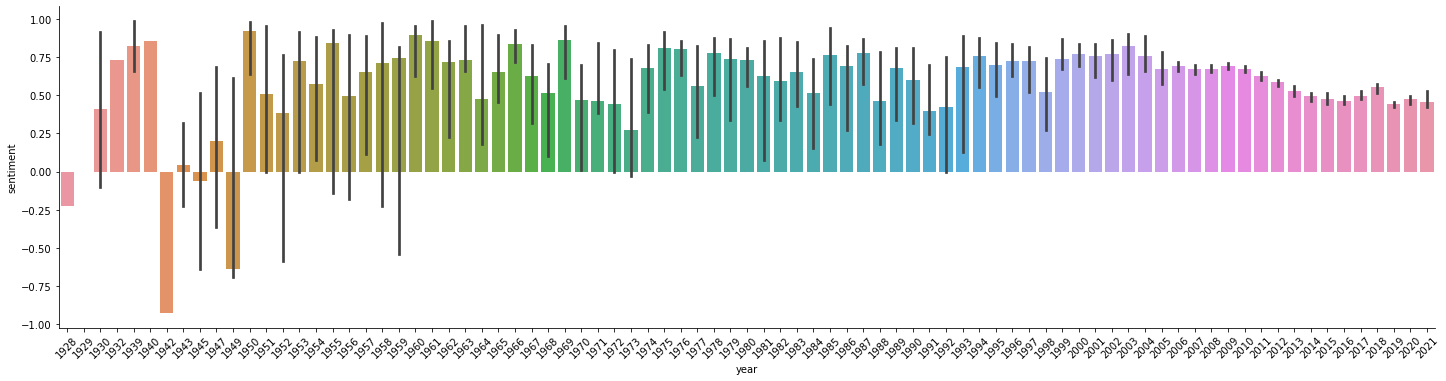

In [44]:
g = sns.catplot(x="year", y="sentiment", estimator= np.median ,kind="bar", data=ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

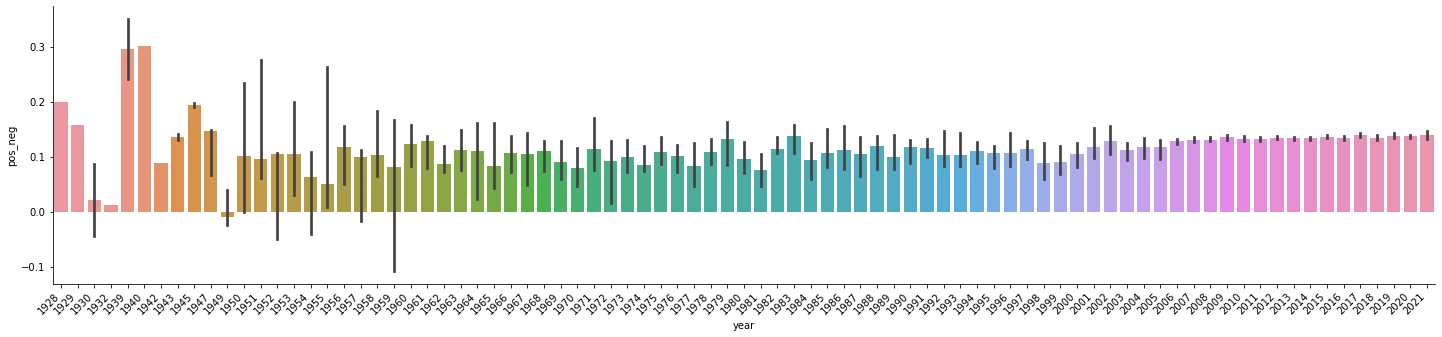

In [45]:
g = sns.catplot(x="year", y="pos_neg", estimator= np.median ,kind="bar", data=ufo_df, height=5, aspect=4)
g.fig.autofmt_xdate()
g.set_xticklabels(rotation=45)

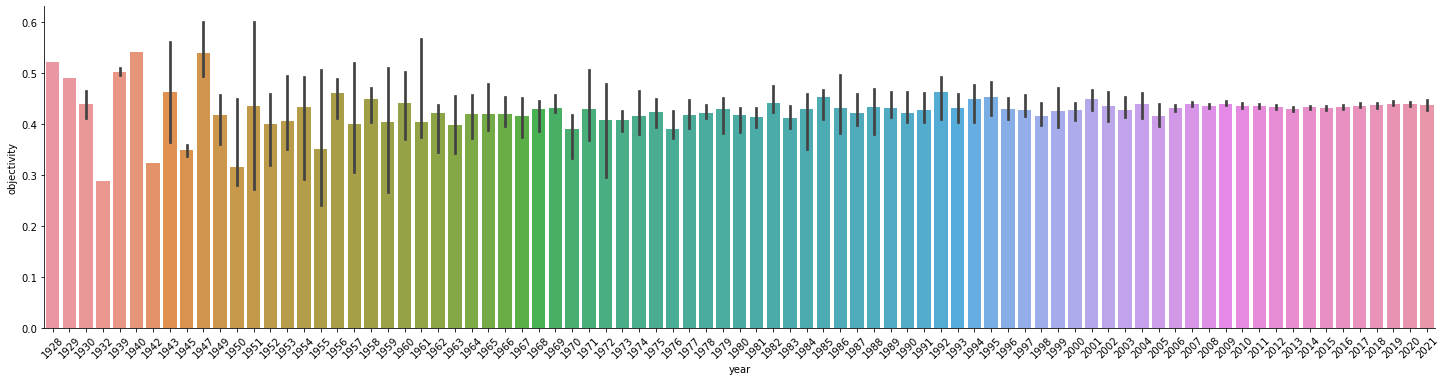

In [46]:
g = sns.catplot(x="year", y="objectivity", estimator= np.median ,kind="bar", data=ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

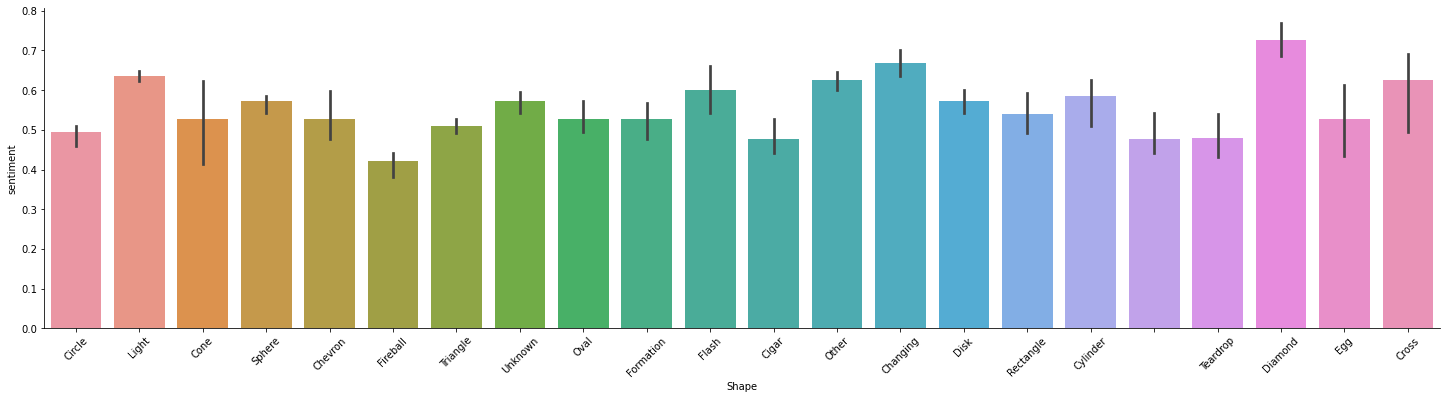

In [47]:
g = sns.catplot(x="Shape", y="sentiment", estimator= np.median ,kind="bar", data=ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

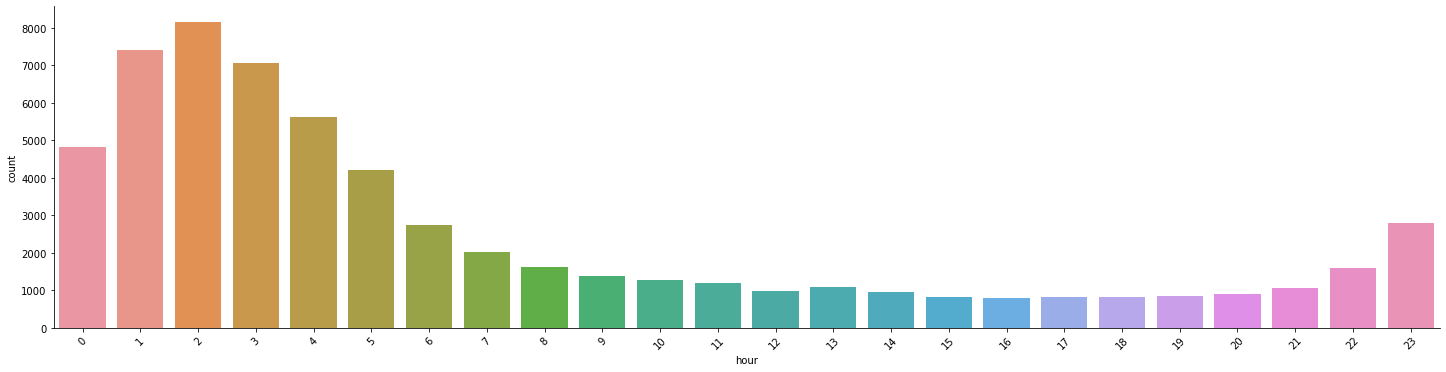

In [48]:
g = sns.catplot(x="hour", kind = 'count', data = ufo_df, height=5, aspect=4)
g.set_xticklabels(rotation=45)

In [49]:
#define borders for map
#BBox = ((ufo_df.Lon.min(),   ufo_df.Lon.max(), ufo_df.Lat.min(), ufo_df.Lat.max()))

BBox = (-125.859, -92.681, 25.562, 49.781)

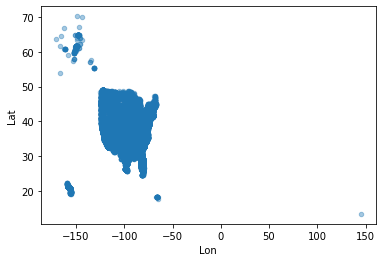

In [50]:
ufo_df.plot(kind="scatter", x="Lon", y="Lat", alpha=0.4)
plt.show()

In [51]:
states_sentiment = ufo_df.groupby(['State'])['sentiment'].max().reset_index()
states_sentiment

,State,sentiment
0,,0.9753
1,AK,0.9909
2,AL,0.9908
3,AR,0.9983
4,AZ,0.9985
5,BC,0.9771
6,CA,0.9993
7,CO,0.9980
8,CT,0.9968
9,DC,0.9666


In [52]:
states_objectivity = ufo_df.groupby(['State'])['objectivity'].median().reset_index()

In [53]:
states_count = ufo_df.groupby(['State']).size().reset_index()
states_count.rename(columns = {0:'Count'}, inplace = True)


In [54]:
sightingsDict = {states_count.iloc[i][0]:states_count.iloc[i][1] for i in range(len(states_count.State))}
sightingsDict["PR"] = None

objectDict = {states_objectivity.iloc[i][0]:states_objectivity.iloc[i][1] for i in range(len(states_objectivity.State))}
objectDict["PR"] = None

sentimentDict = {states_sentiment.iloc[i][0]:states_sentiment.iloc[i][1] for i in range(len(states_sentiment.State))}
sentimentDict["PR"] = None

In [55]:
state_abr = {"Hawaii":"HI", "Alaska":"AK", "Washington":"WA", "Oregon":"OR", "California":"CA",
                        "Arizona":"AZ", "Utah":"UT", "Idaho":"ID", "Montana":"MT", "Wyoming":"WY", "Colorado":"CO",
                        "New Mexico":"NM", "Texas":"TX", "Oklahoma":"OK", "Kansas":"KS", "Nebraska":"NE", 
                        "South Dakota":"SD", "North Dakota":"ND", "Minnesota":"MN", "Iowa":"IA", "Missouri":"MO",
                        "Arkansas":"AR", "Louisiana":"LA", "Wisconsin":"WI", "Illinois":"IL", "Mississippi":"MS",
                        "Alabama":"AL", "Georgia":"GA", "Florida":"FL", "Tennessee":"TN", "Kentucky":"KY", "Indiana":"IN",
                        "Michigan":"MI", "South Carolina":"SC", "North Carolina":"NC", "Virginia":"VA",
                        "West Virginia":"WV", "Ohio":"OH", "Pennsylvania":"PA", "Maryland":"MD", "Delaware":"DE",
                        "New Jersey":"NJ", "New York":"NY", "Connecticut":"CT", "Rhode Island":"RI", 
                        "Massachusetts":"MA", "Vermont":"VT", "New Hampshire":"NH", "Maine":"ME",
                        "District of Columbia":"DC", "Nevada":"NV", "Puerto Rico":"PR"}

In [56]:
state_pop = pd.read_csv('StatesPop.csv')
state_pop.State.replace(state_abr, inplace=True)

# The proportion of each state's population to the nation's population: the sum of the Proportions is 1
state_pop["Proportion"] = state_pop.Pop/state_pop.Pop.sum()

# The ratio of the number of sightings to the each state's population. Note that Puerto Rico (PR) is NaN.
state_pop["Sightings"] = pd.Series([sightingsDict[state_pop.State[i]] for i in range(len(state_pop.State))])
state_pop["Sightings_per_capita"] = state_pop.Sightings/state_pop.Pop

# sentiment weighted by proportion of state population to national population
state_pop["Sentiment"] = pd.Series([sentimentDict[state_pop.State[i]] for i in range(len(state_pop.State))])
state_pop["Weighted_sentiment"] = state_pop.Sentiment*state_pop.Proportion

# objectivity weighted by proportion of state population to national population
state_pop["Objectivity"] = pd.Series([objectDict[state_pop.State[i]] for i in range(len(state_pop.State))])
state_pop["Weighted_objectivity"] = state_pop.Objectivity*state_pop.Proportion

state_pop.head(5)

,rank,State,Pop,Growth,Pop2018,Pop2010,growthSince2010,Percent,density,Proportion,Sightings,Sightings_per_capita,Sentiment,Weighted_sentiment,Objectivity,Weighted_objectivity
0,1,CA,39613493,0.0038,39461588,37319502,0.0615,0.1184,254.2929,0.118413,7142.0,0.000180,0.9993,0.118330,0.437075,0.051755
1,2,TX,29730311,0.0385,28628666,25241971,0.1778,0.0889,113.8081,0.088870,2681.0,0.000090,0.9987,0.088754,0.433333,0.038510
2,3,FL,21944577,0.0330,21244317,18845537,0.1644,0.0656,409.2229,0.065597,4135.0,0.000188,0.9998,0.065584,0.430303,0.028226
3,4,NY,19299981,-0.0118,19530351,19399878,-0.0051,0.0577,409.5400,0.057691,2562.0,0.000133,0.9986,0.057611,0.433333,0.025000
4,5,PA,12804123,0.0003,12800922,12711160,0.0073,0.0383,286.1704,0.038274,2487.0,0.000194,0.9976,0.038182,0.429167,0.016426


In [58]:
religion_2007 = 'Religious Landscape Survey Data - Continental US.sav'
religion2007df, metadata = pyreadstat.read_sav(religion_2007, apply_value_formats=True)

In [59]:
religion_2014 = 'Dataset - Pew Research Center 2014 Religious Landscape Study National Telephone Survey - Version 1.1 - December 1 2016.sav'
religion2014df, metadata = pyreadstat.read_sav(religion_2014, apply_value_formats=True)

In [60]:
religion2007df.head()

,weight,psraid,int_date,lang,type,cregion,state,usr,usr1,form,...,q63,educ,income,regist,regicert,party,partyln,ideo,pvote04a,pvote04b
0,4.512821,10000001.0,50807.0,English,RDD,Northeast,Connecticut,Suburban,Suburban,Form A,...,"Yes, father born outside U.S.","Technical, trade, or vocational school AFTER h...","75 to under $100,000","Yes, registered",Absolutely certain,Republican,NaN,Moderate,Voted,Bush
1,2.102564,10000002.0,50807.0,English,RDD,Northeast,Maine,Rural,Rural,Form B,...,"No, both parents born in U.S.",High school graduate (Grade 12 or GED certific...,"20 to under $30,000","No, not registered",NaN,Republican,NaN,Conservative,Did not vote (includes too young to vote),NaN
2,1.282051,10000003.0,50807.0,English,RDD,Northeast,Maine,Rural,Rural,Form A,...,"No, both parents born in U.S.","College graduate (B.S., B.A., or other 4-year ...","30 to under $40,000","No, not registered",NaN,Independent,Democrat,Conservative,Did not vote (includes too young to vote),NaN
3,1.355323,10000004.0,50807.0,English,RDD,Northeast,Maine,Rural,Rural,Form B,...,"No, both parents born in U.S.","Some college, no 4-year degree (including asso...","Less than $10,000","No, not registered",NaN,Independent,Democrat,Moderate,Did not vote (includes too young to vote),NaN
4,1.589744,10000005.0,50807.0,English,RDD,Northeast,New York,Urban,Urban,Form A,...,"Yes, father born outside U.S.",Post-graduate training or professional schooli...,"50 to under $75,000","Yes, registered",Absolutely certain,Independent,Democrat,Moderate,Voted,Other candidate


In [61]:
list(religion2007df['party'].unique())

['Republican',
 'Independent',
 'Democrat',
 "Don't know/Refused",
 'No preference (VOL.)',
 'Other party (VOL.)']

In [62]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
religion_encoded = le.fit_transform(religion2007df['q16'])
religion_encoded

array([44, 44, 44, ..., 47, 47, 39])

In [63]:
relByState = religion2007df.groupby("state")['q16'].apply(lambda x: x.tolist()).reset_index()

#import plotly.express as px
#for i in range(len(relByState)):
#    fig = px.histogram(relByState, x=relByState['q16'][i], title=relByState['state'][i])
#    fig.show()

religion2007df_reduced = religion2007df[['state', 'q16', 'party']].copy().apply(lambda x: x.str.strip())


def relCode(x):
    if x == 'Nothing in particular' or x == 'Atheist (do not believe in God)' \
    or x== 'Agnostic (not sure if there is a God)' or x=='Nihilist (VOL)':
        return 0
    elif x == 'Protestant':
        return 1
    elif x == 'Mormon (Church of Jesus Christ of Latter-day Saints/LDS)':
        return 2
    elif x == 'Roman Catholic':
        return 3
    elif x == 'Jewish (Judaism)':
        return 4
    else:
        return 5

    
def partyCode(x):
    if x == 'Republican':
        return 1
    elif x == 'Democrat':
        return 2
    elif x == 'Independent':
        return 3
    else:
        return 0

religion2007df_reduced['relCode2007'] = religion2007df_reduced['q16'].apply(relCode)
religion2007df_reduced['partyCode2007'] = religion2007df_reduced['party'].apply(partyCode)

relByStateRed2007 = religion2007df_reduced.groupby("state")['relCode2007'].apply(lambda x: x.tolist()).reset_index()
partyByStateRed2007 = religion2007df_reduced.groupby("state")['partyCode2007'].apply(lambda x: x.tolist()).reset_index()

#for i in range(len(relByStateRed)):
#    fig = px.histogram(relByStateRed, x=relByStateRed['relCode'][i], title=relByStateRed['state'][i])
#    fig.show()

relByStateRed2007['relFreq2007'] = relByStateRed2007['relCode2007'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
partyByStateRed2007['partyFreq2007'] = partyByStateRed2007['partyCode2007'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
split_reldf = pd.DataFrame(relByStateRed2007['relFreq2007'].tolist(), columns=['rel0_2007', 'rel1_2007', 'rel2_2007', 'rel3_2007', 'rel4_2007', 'rel5_2007'])
split_partydf = pd.DataFrame(partyByStateRed2007['partyFreq2007'].tolist(), columns=['par0_2007', 'par1_2007', 'par2_2007', 'par3_2007'])

byState = relByStateRed2007[['state']].join(split_reldf).join(split_partydf)
byState.head()

,state,rel0_2007,rel1_2007,rel2_2007,rel3_2007,rel4_2007,rel5_2007,par0_2007,par1_2007,par2_2007,par3_2007
0,Alabama,0.071953,0.826725,0.004405,0.066079,0.001468,0.029369,0.120411,0.330396,0.317181,0.232012
1,Arizona,0.200692,0.394464,0.041522,0.249135,0.015571,0.098616,0.114187,0.302768,0.254325,0.328720
2,Arkansas,0.092593,0.804233,0.005291,0.047619,0.050265,NaN,0.108466,0.227513,0.380952,0.283069
3,California,0.198657,0.019026,0.026021,0.340795,0.267208,0.148293,0.114717,0.340515,0.239508,0.305260
4,Colorado,0.227119,0.427119,0.022034,0.189831,0.022034,0.111864,0.064407,0.269492,0.262712,0.403390


In [67]:
relByStateRed2007.relFreq2007[1]

[0.20069204152249134,
 0.3944636678200692,
 0.04152249134948097,
 0.2491349480968858,
 0.015570934256055362,
 0.0986159169550173]

In [68]:
print(list(religion2014df.columns))

['resp', 'qsamptyp', 'qlan', 'state', 'cregion', 'WEIGHT', 'WGT_ATL_MSA', 'WGT_BAL_MSA', 'WGT_BOS_MSA', 'WGT_CHI_MSA', 'WGT_DAL_MSA', 'WGT_DC_MSA', 'WGT_DET_MSA', 'WGT_HOU_MSA', 'WGT_LA_MSA', 'WGT_MIA_MSA', 'WGT_MIN_MSA', 'WGT_NYC_MSA', 'WGT_PHI_MSA', 'WGT_PHO_MSA', 'WGT_PIT_MSA', 'WGT_PRO_MSA', 'WGT_RIV_MSA', 'WGT_SDI_MSA', 'WGT_SEA_MSA', 'WGT_SF_MSA', 'WGT_STL_MSA', 'WGT_TMP_MSA', 'qa1', 'qa2a', 'qa2b', 'qb1a', 'qb1b', 'qb1c', 'qb2a', 'qb2b', 'qb2c', 'qb2d', 'qb20', 'qb21', 'qb22', 'qb30', 'qb30b', 'qb31', 'marital', 'hisp', 'racecmb', 'racethn', 'qe1', 'qe2', 'qe3a', 'qe3b', 'qe3c', 'qe3d', 'qe3e', 'qe3f', 'qe3g', 'qe3h', 'qe3i', 'qe3j', 'qe3k', 'qe3l', 'qe3m', 'qe3n', 'qe3q', 'qe3r', 'qe3s', 'qe3t', 'qe3u', 'qe3v', 'born', 'DENOM', 'FAMILY', 'RELTRAD', 'PROTFAM', 'attend', 'qf2', 'qf5', 'qg1', 'qg1b', 'qg1c', 'qg3', 'qg5', 'qg6', 'qg7', 'qg7b', 'qh1', 'qh2', 'qh4', 'qi1', 'qi2a', 'qi2b', 'qi2c', 'qi2d', 'qi2g', 'qi2h', 'qi2m', 'qi2t', 'qi2u', 'qi3', 'qi3b', 'qi4a', 'qi4b', 'qi4c', 

In [69]:
list(religion2014df.party.unique())

['Independent',
 'Republican',
 "(VOL) Don't know/Refused",
 '(VOL) No preference',
 'Democrat',
 '(VOL) Other party']

In [70]:
relByState2014 = religion2014df.groupby("state")['qe1'].apply(lambda x: x.tolist()).reset_index()

#import plotly.express as px
#for i in range(len(relByState2014)):
#    fig = px.histogram(relByState2014, x=relByState['qe1'][i], title=relByState['state'][i])
#    fig.show()

religion2014df_reduced = religion2014df[['state', 'qe1', 'party']].copy().apply(lambda x: x.str.strip())


religion2014df_reduced['relCode2014'] = religion2014df_reduced['qe1'].apply(relCode)
religion2014df_reduced['partyCode2014'] = religion2014df_reduced['party'].apply(partyCode)

relByStateRed2014 = religion2014df_reduced.groupby("state")['relCode2014'].apply(lambda x: x.tolist()).reset_index()
partyByStateRed2014 = religion2014df_reduced.groupby("state")['partyCode2014'].apply(lambda x: x.tolist()).reset_index()

#for i in range(len(relByStateRed)):
#    fig = px.histogram(relByStateRed, x=relByStateRed['relCode'][i], title=relByStateRed['state'][i])
#    fig.show()

pd.Series(relByStateRed2014.relCode2014[0]).value_counts(sort=False, normalize = True).tolist()

relByStateRed2014['relFreq2014'] = relByStateRed2014['relCode2014'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
partyByStateRed2014['partyFreq2014'] = partyByStateRed2014['partyCode2014'].apply(lambda x: 
                                                          pd.Series(x).value_counts(sort=False, 
                                                                                    normalize = True).tolist())
split_reldf14 = pd.DataFrame(relByStateRed2014['relFreq2014'].tolist(), columns=['rel0_2014', 'rel1_2014', 'rel2_2014', 'rel3_2014', 'rel4_2014', 'rel5_2014'])
split_partydf14 = pd.DataFrame(partyByStateRed2014['partyFreq2014'].tolist(), columns=['par0_2014', 'par1_2014', 'par2_2014', 'par3_2014'])

byState = byState.join(split_reldf14).join(split_partydf14)
byState.head()

,state,rel0_2007,rel1_2007,rel2_2007,rel3_2007,rel4_2007,rel5_2007,par0_2007,par1_2007,par2_2007,...,rel0_2014,rel1_2014,rel2_2014,rel3_2014,rel4_2014,rel5_2014,par0_2014,par1_2014,par2_2014,par3_2014
0,Alabama,0.071953,0.826725,0.004405,0.066079,0.001468,0.029369,0.120411,0.330396,0.317181,...,0.099804,0.761252,0.007828,0.074364,0.003914,0.052838,0.099804,0.320939,0.260274,0.318982
1,Arizona,0.200692,0.394464,0.041522,0.249135,0.015571,0.098616,0.114187,0.302768,0.254325,...,0.322581,0.361290,0.035484,0.148387,0.003226,0.129032,0.109677,0.219355,0.161290,0.509677
2,Arkansas,0.092593,0.804233,0.005291,0.047619,0.050265,NaN,0.108466,0.227513,0.380952,...,0.251149,0.395100,0.055130,0.192956,0.019908,0.085758,0.078101,0.287902,0.228178,0.405819
3,California,0.198657,0.019026,0.026021,0.340795,0.267208,0.148293,0.114717,0.340515,0.239508,...,0.170418,0.691318,0.009646,0.070740,0.057878,NaN,0.096463,0.250804,0.254019,0.398714
4,Colorado,0.227119,0.427119,0.022034,0.189831,0.022034,0.111864,0.064407,0.269492,0.262712,...,0.281850,0.015959,0.033811,0.309981,0.237490,0.120909,0.096024,0.341628,0.201785,0.360563


In [71]:
byState.state.unique()

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida',
       'Georgia', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma',
       'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)

In [72]:
features = pd.merge(byState, byStateSentObj, on='state', how='inner')
features.head()

/Users/daisy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/Users/daisy/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


,state,rel0_2007,rel1_2007,rel2_2007,rel3_2007,rel4_2007,rel5_2007,par0_2007,par1_2007,par2_2007,...,par0_2014,par1_2014,par2_2014,par3_2014,"(sentiment_nltk, mean)","(sentiment_nltk, median)","(sentiment_textBlob, mean)","(sentiment_textBlob, median)","(objectivity, mean)","(objectivity, median)"
0,Alabama,0.071953,0.826725,0.004405,0.066079,0.001468,0.029369,0.120411,0.330396,0.317181,...,0.099804,0.320939,0.260274,0.318982,0.404351,0.5854,0.130834,0.125000,0.423527,0.421429
1,Arizona,0.200692,0.394464,0.041522,0.249135,0.015571,0.098616,0.114187,0.302768,0.254325,...,0.109677,0.219355,0.161290,0.509677,0.395320,0.5106,0.137800,0.134178,0.433162,0.436127
2,Arkansas,0.092593,0.804233,0.005291,0.047619,0.050265,NaN,0.108466,0.227513,0.380952,...,0.078101,0.287902,0.228178,0.405819,0.392786,0.5134,0.147803,0.142532,0.435235,0.429107
3,California,0.198657,0.019026,0.026021,0.340795,0.267208,0.148293,0.114717,0.340515,0.239508,...,0.096463,0.250804,0.254019,0.398714,0.453188,0.6124,0.134659,0.133226,0.434801,0.437131
4,Colorado,0.227119,0.427119,0.022034,0.189831,0.022034,0.111864,0.064407,0.269492,0.262712,...,0.096024,0.341628,0.201785,0.360563,0.422704,0.5859,0.140124,0.136429,0.437441,0.440328


In [73]:
#save file
fileName = 'featuresCapstone.pkl'
features.to_pickle(fileName)